In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

class ConditionalNormalDataGenerator:
    def __init__(self, mean_function, variance_function, size=10_000, random_state=None):
        self.mean_function = mean_function
        self.variance_function = variance_function
        self.size = size
        self.random_state = random_state

        # la géneration des seeds deterministes pour X et bruit
        self._rng = np.random.RandomState(self.random_state)
        self._seeds = self._rng.randint(0, 2**32 - 1, size=2, dtype=np.int64)

    def generate(self):
        rng_x = np.random.RandomState(self._seeds[0])
        rng_noise = np.random.RandomState(self._seeds[1])

        X = rng_x.uniform(size=self.size)
        y_mean = self.mean_function(X)
        y_std = self.variance_function(X)
        noise = rng_noise.normal(loc=0, scale=y_std)

        y_noisy = y_mean + noise
        return X, y_noisy

In [ ]:
def mean_function(X):
    return np.cos(2 * np.pi * X)

def variance_function(X):
    return 0.3 - 0.1 * mean_function(X)

generator = ConditionalNormalDataGenerator(
    mean_function=mean_function,
    variance_function=variance_function,
    size=10_000,
    random_state=42,
)

X, y = generator.generate()

In [28]:
def gaussian_kernel(X, x_value, bandwidth):
    weights = np.exp(-0.5 * ((X - x_value) / bandwidth) ** 2)
    weights /= weights.sum()
    return weights

x_value = 0.2
weights = gaussian_kernel(X, x_value = x_value, bandwidth = .01)

kde = gaussian_kde(y, bw_method="scott", weights=weights)

y_grid_refined = np.linspace(y.min() - 0.5, y.max() + 0.5, 500)
bins = np.linspace(y.min(), y.max(), 30)

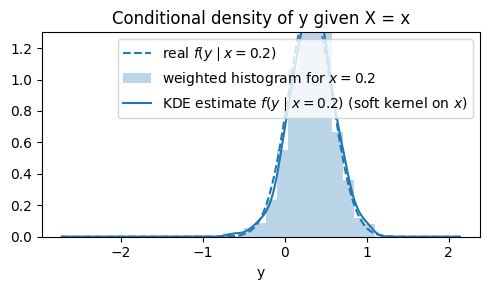

In [29]:
fig, ax = plt.subplots(figsize=(5, 3))

# ground truth conditional
ax.plot(
    y_grid_refined,
    norm(
        loc=mean_function(x_value), 
        scale=variance_function(x_value)
    ).pdf(y_grid_refined),
    "--",
    color="C0",
    label=fr"real $f(y \mid x = {x_value})$"
)

# l'histogram ponderé
ax.hist(
    y,
    weights=weights,
    bins=bins,
    alpha=0.3,
    density=True,
    color="C0",
    label=fr"weighted histogram for $x = {x_value}$"
)

# l'estimateur KDE
ax.plot(
    y_grid_refined,
    kde(y_grid_refined),
    color="C0",
    label=fr"KDE estimate $f(y \mid x = {x_value})$ (soft kernel on $x$)"
)

ax.set_title("Conditional density of y given X = x")
ax.set_xlabel("y")
ax.set_ylim(0, 1.3)
ax.legend()
plt.tight_layout()
plt.show()